# Churn Prediction with Machine Learning
## Thiago Pádua de Carvalho - 2020007066

### Introdução - O que é Churn?
Churn é o termo que define a taxa de evasão de clientes de um serviço ou produto fornecido por uma empresa. Ele é um elemento fundamental para medir a fidelidade e a satisfação dos consumidores, um indicador importante para a saúde financeira de uma companhia, análise de situação no mercado e consequente tomada de decisões estratégicas.

Entender o comportamento dos compradores e prever sua evasão é um desafio para as empresas, pois esse fenômeno está diretamente relacionado com a perda de receita e viabilidade do negócio. Sendo assim é fundamental ter informações sobre o que leva um cliente a cancelar um serviço para identificar pontos de falha, tal como investir assertivamente em ações de retenção.

Com isso em mente, o objetivo deste trabalho é construir um modelo de Machine Learning para prever o churn, tal como identificar aqueles atributos que mais contribuem para a evasão de clientes, permitindo uma visão ampla e detalhada sobre o problema para a posterior tomada de decisões.

![alt text](blog-startup-churn.png "Churn representative image")

### Importação das bibliotecas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder

## Conhecendo os dados
O dataset utilizado neste trabalho é composto por dois arquivos CSV: um para treinamento e outro para teste.

O arquivo de treinamento para o conjunto de dados de churn contém uma coleção de 440.882 registros de clientes, juntamente com suas respectivas características e rótulos binários. Cada linha no arquivo de treinamento representa um cliente e inclui as seguintes características: idade, gênero, tempo de serviço, frequência de uso, chamadas de suporte, atraso no pagamento, tipo de assinatura, duração do contrato, gasto total e última interação.

O arquivo de teste para o conjunto de dados de churn consiste em 64.374 registros de clientes e serve como um conjunto de dados separado para avaliar o desempenho e a capacidade de generalização dos modelos de previsão de rotatividade treinados. Cada linha no arquivo de teste corresponde a um cliente e contém o mesmo conjunto de características que o arquivo de treinamento. No entanto, os rótulos de churn não estão incluídos no arquivo de teste, pois são usados para avaliar a precisão e a eficácia dos modelos. O arquivo de teste permite avaliar o poder preditivo dos modelos treinados em dados não vistos e obter insights sobre o quão bem eles se generalizam para novos clientes.

Fonte dos dados: https://www.kaggle.com/datasets/muhammadshahidazeem/customer-churn-dataset?resource=download&select=customer_churn_dataset-testing-master.csv

### Feature Columns
Atributos numéricos:
- **Age**: Idade
- **Tenure**: Duração em Meses do tempo que o cliente consome o serviço
- **Usage Frequency**: número de vezes que o cliente usou o serviço no mês anterior
- **Support Calls**: número de chamadas de suporte feitas pelo cliente no mês anterior
- **Payment Delay**: número de dias de atraso no pagamento do cliente para o mês anteriror
- **Total Spend**: gasto total do cliente com o serviço
- **Last Interaction**: número de dias desde a última interação do cliente com o serviço

Atributos categóricos
- **Gender**: Sexo do cliente (M/F)
- **Subscription Type**: Tipo de assinatura do cliente (Standard, Basic, Premium)
- **Contract Length**: Tipo de duração do contrato do cliente (Annual, Monthly, Quarterly)



### Carregamento dos dados

In [2]:
trainingData = pd.read_csv('data/customer_churn_dataset-training-master.csv')
trainingData.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [3]:
testData = pd.read_csv('data/customer_churn_dataset-testing-master.csv')
testData.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


### Pré-processamento

In [4]:
trainingData.replace([np.inf, -np.inf], np.nan, inplace=True)
trainingData = trainingData.dropna()
trainingData.drop(['CustomerID'], axis=1, inplace=True)
X_train, y_train = trainingData.drop('Churn', axis=1), trainingData['Churn']

In [5]:
testData.replace([np.inf, -np.inf], np.nan, inplace=True)
testData = testData.dropna()
testData.drop(['CustomerID'], axis=1, inplace=True)
X_test, y_test = testData.drop('Churn', axis=1), testData['Churn']

## Análise Exploratória de Dados (EDA)
Antes de pensar em algoritmos de predição, é importante entender melhor os dados, identificar padrões e relações entre as variáveis. Conhecer as distribuições, outliers, correlações e outras informações relevantes é fundamental para formar modelos mais robustos e eficazes.

### Distribuição dos rótulos de churn
Estamos interessados em saber como os dados de treinamento e teste estão dispostos em torno do rótulo de churn. A partir dos gráficos abaixo, podemos observar que a distribuição dos rótulos de churn é bastante equilibrada em ambos os conjuntos de dados, o que é uma boa notícia, pois evita problemas de desbalanceamento de classes.

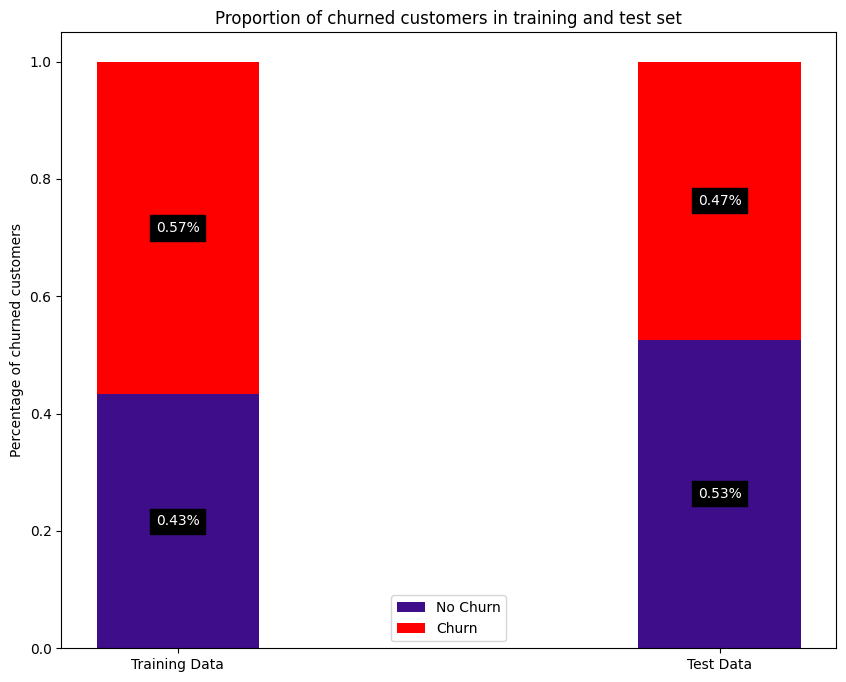

In [6]:
# Calculate proportions for the two segments
def calculate_proportions(dataset):
    num_churn = dataset.sum()
    num_non_churn = len(dataset) - num_churn

    num_churn /=len(dataset)
    num_non_churn /= len(dataset)
    return num_churn, num_non_churn

num_churn_train, num_non_churn_train = calculate_proportions(y_train)
num_churn_test, num_non_churn_test = calculate_proportions(y_test)

fig, ax = plt.subplots(figsize=(10, 8))

ax.text('Training Data', num_non_churn_train/2, f'{num_non_churn_train:.2f}%', ha='center', va='center', color='white', backgroundcolor='black')
ax.bar('Training Data', num_non_churn_train, color='#3e0d8a', label='No Churn', width=0.3)
ax.text('Training Data', num_non_churn_train + num_churn_train/2, f'{num_churn_train:.2f}%', ha='center', va='center', color='white', backgroundcolor='black')
ax.bar('Training Data', num_churn_train, color='red', label='Churn', bottom=num_non_churn_train, width=0.3)

ax.text('Test Data', num_non_churn_test/2, f'{num_non_churn_test:.2f}%', ha='center', va='center', color='white', backgroundcolor='black')
ax.bar('Test Data', num_non_churn_test, color='#3e0d8a', width=0.3)
ax.text('Test Data', num_non_churn_test + num_churn_test/2, f'{num_churn_test:.2f}%', ha='center', va='center', color='white', backgroundcolor='black')
ax.bar('Test Data', num_churn_test, color='red', bottom=num_non_churn_test, width=0.3)

plt.ylabel('Percentage of churned customers')
plt.legend()
plt.title('Proportion of churned customers in training and test set')
plt.show()


### Análise das Features
Primeiramente vamos buscar entender melhor as variáveis numéricas e categóricas, observando a presença de outliers e principalmente a distribuição dos dados.

In [7]:
trainingData.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000,440832.000000
mean,39.373153,31.256336,15.807494,3.604437,12.965722,631.616223,14.480868,0.567107
std,12.442369,17.255727,8.586242,3.070218,8.258063,240.803001,8.596208,0.495477
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,29.000000,16.000000,9.000000,1.000000,6.000000,480.000000,7.000000,0.000000
50%,39.000000,32.000000,16.000000,3.000000,12.000000,661.000000,14.000000,1.000000
75%,48.000000,46.000000,23.000000,6.000000,19.000000,830.000000,22.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


#### 1 - Total gasto

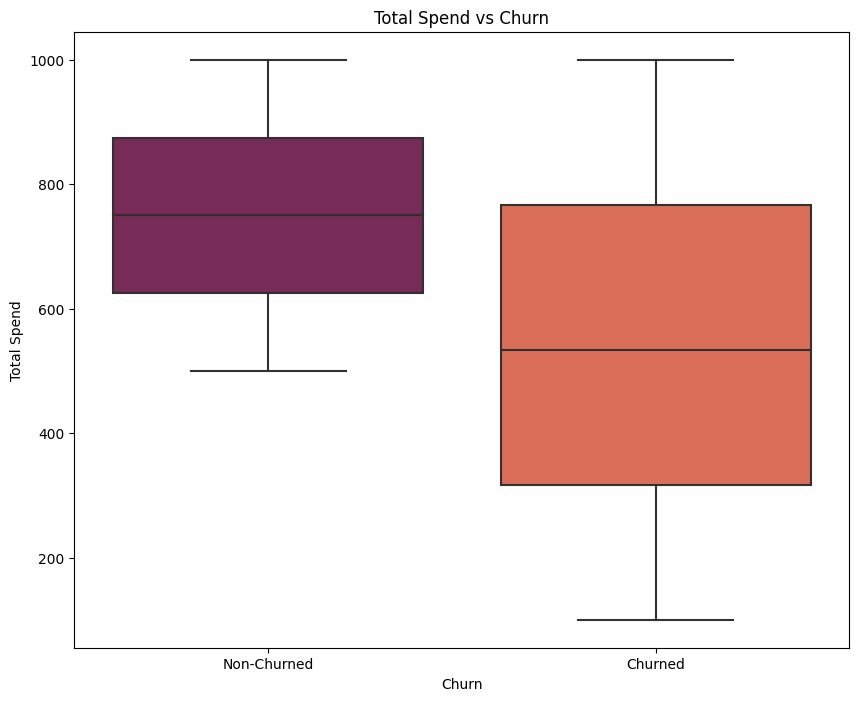

In [8]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Churn', y='Total Spend', data=trainingData, palette='rocket')
plt.xlabel('Churn')
plt.ylabel('Total Spend')
plt.title('Total Spend vs Churn')
plt.xticks([0, 1], ['Non-Churned', 'Churned'])
plt.show()

In [9]:
# calculate the mean of total spend for churned and non churned customers
mean_total_spend_churn = trainingData[trainingData['Churn'] == 1]['Total Spend'].mean()
mean_total_spend_non_churn = trainingData[trainingData['Churn'] == 0]['Total Spend'].mean()

print(f'Mean total spend for churned customers: {mean_total_spend_churn:.2f}')
print(f'Mean total spend for non-churned customers: {mean_total_spend_non_churn:.2f}')

Mean total spend for churned customers: 541.29
Mean total spend for non-churned customers: 749.95


Uma métrica interessante a se avaliar é a do total gasto pelos clientes. A média de gastos geral é de 631.6, porém ela varia consideravelmente quando consideramos o churn. Clientes que cancelaram o serviço tendem a gastar menos, com uma média de 541.29, enquanto os que permanecem gastam em média 749.95

#### 2 - Frequência de uso


/home/thiago/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


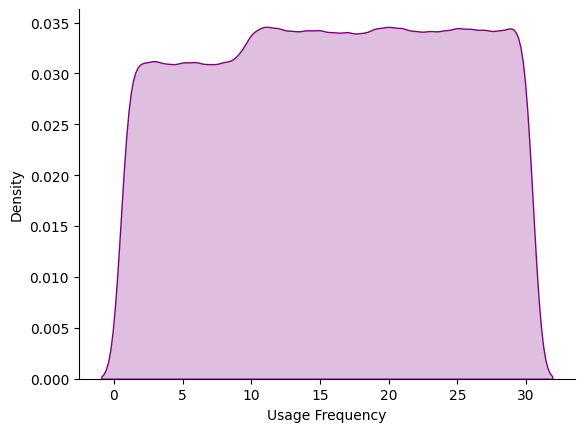

In [10]:
sns.kdeplot(data=trainingData, x='Usage Frequency', fill=True, color='purple')
sns.despine()
plt.show()

A frequência de uso se mantém praticamente constante, não havendo uma concetração de valores expressiva em nenhum ponto. Isso demonstra que o produto não tem um 'ponto de saturação' em que os clientes passam a usar menos.

#### 3 - Última interação

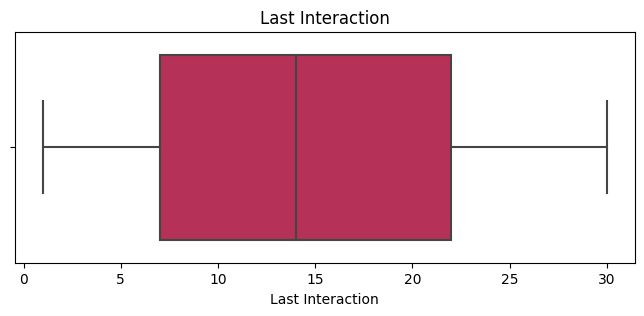

In [11]:
plt.figure(figsize=(8, 3))
sns.boxplot(x=X_train['Last Interaction'], palette='rocket')
plt.xlabel('Last Interaction')
plt.title('Last Interaction')
plt.show()

Pelo boxplot acima, pode-se perceber que a maioria das interações está concentrada entre 8 e 22 dias, indicando que as recentes são comuns, mas também há uma variação razoável no tempo desde a última. Os valores são dispersos e existem tanto clientes cuja última interação foi 30 dias antes quanto clientes que interagiram com o serviço no dia anterior.

#### 4 - Tenure (tempo de engajamento do cliente)

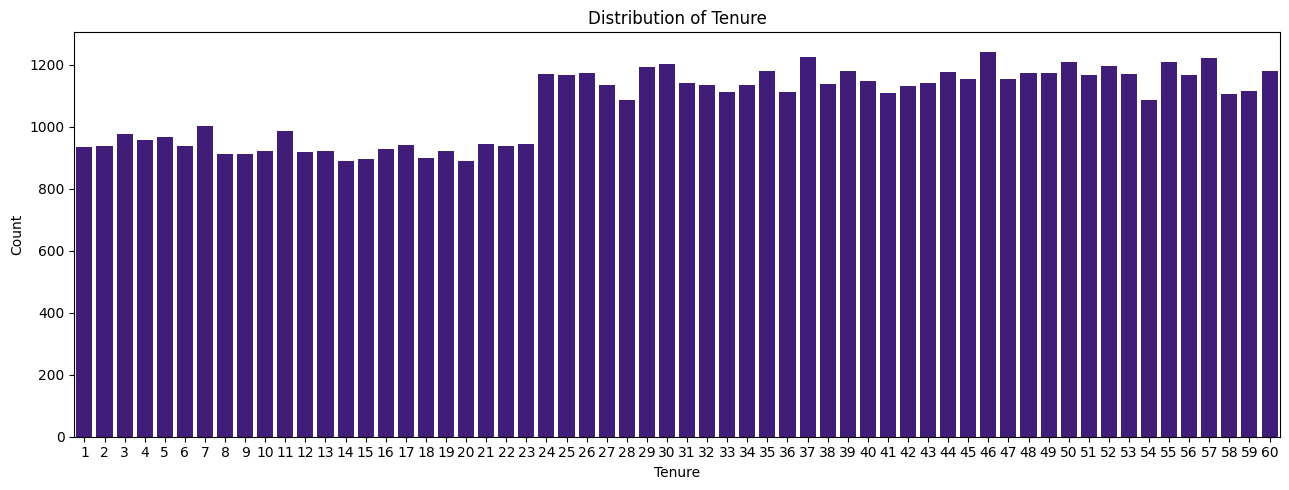

In [12]:
plt.figure(figsize=(13, 5))
sns.countplot(x='Tenure', data=X_test, color='#3e0d8a')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.title('Distribution of Tenure')
plt.tight_layout()
plt.show()

Assim como observado para a última interação, o tempo de engajamento do cliente também é bastante variável, com valores entre 1 e 60 meses. Não há uma concentração expressiva em nenhum ponto, indicando que a base de clientes é bastante heterogênea. Além disso, similar ao que foi verificado anteriormente, não existe ponto de saturação, uma vez que nenhuma queda acentuada é vista. Pelo contrário, há mais clientes com tenure maior que 25, o que eventualmente pode indicar tanto fidelidade quanto dificuldade de captação de novos consumidores.

### Histogramas da relação entre as variáveis e o rótulo de churn

A seguir serão apresentados histogramas que mostram a relação entre as variáveis numéricas, as categóricas e o rótulo de churn. A ideia é identificar padrões e comportamentos que possam ser úteis para a construção dos modelos de Machine Learning.

In [13]:
correlationFeatures = trainingData.select_dtypes(include=['int64', 'float64']).columns
numericFeatures = correlationFeatures.drop('Churn')

categoricalFeatures = trainingData.select_dtypes(include=['object']).columns

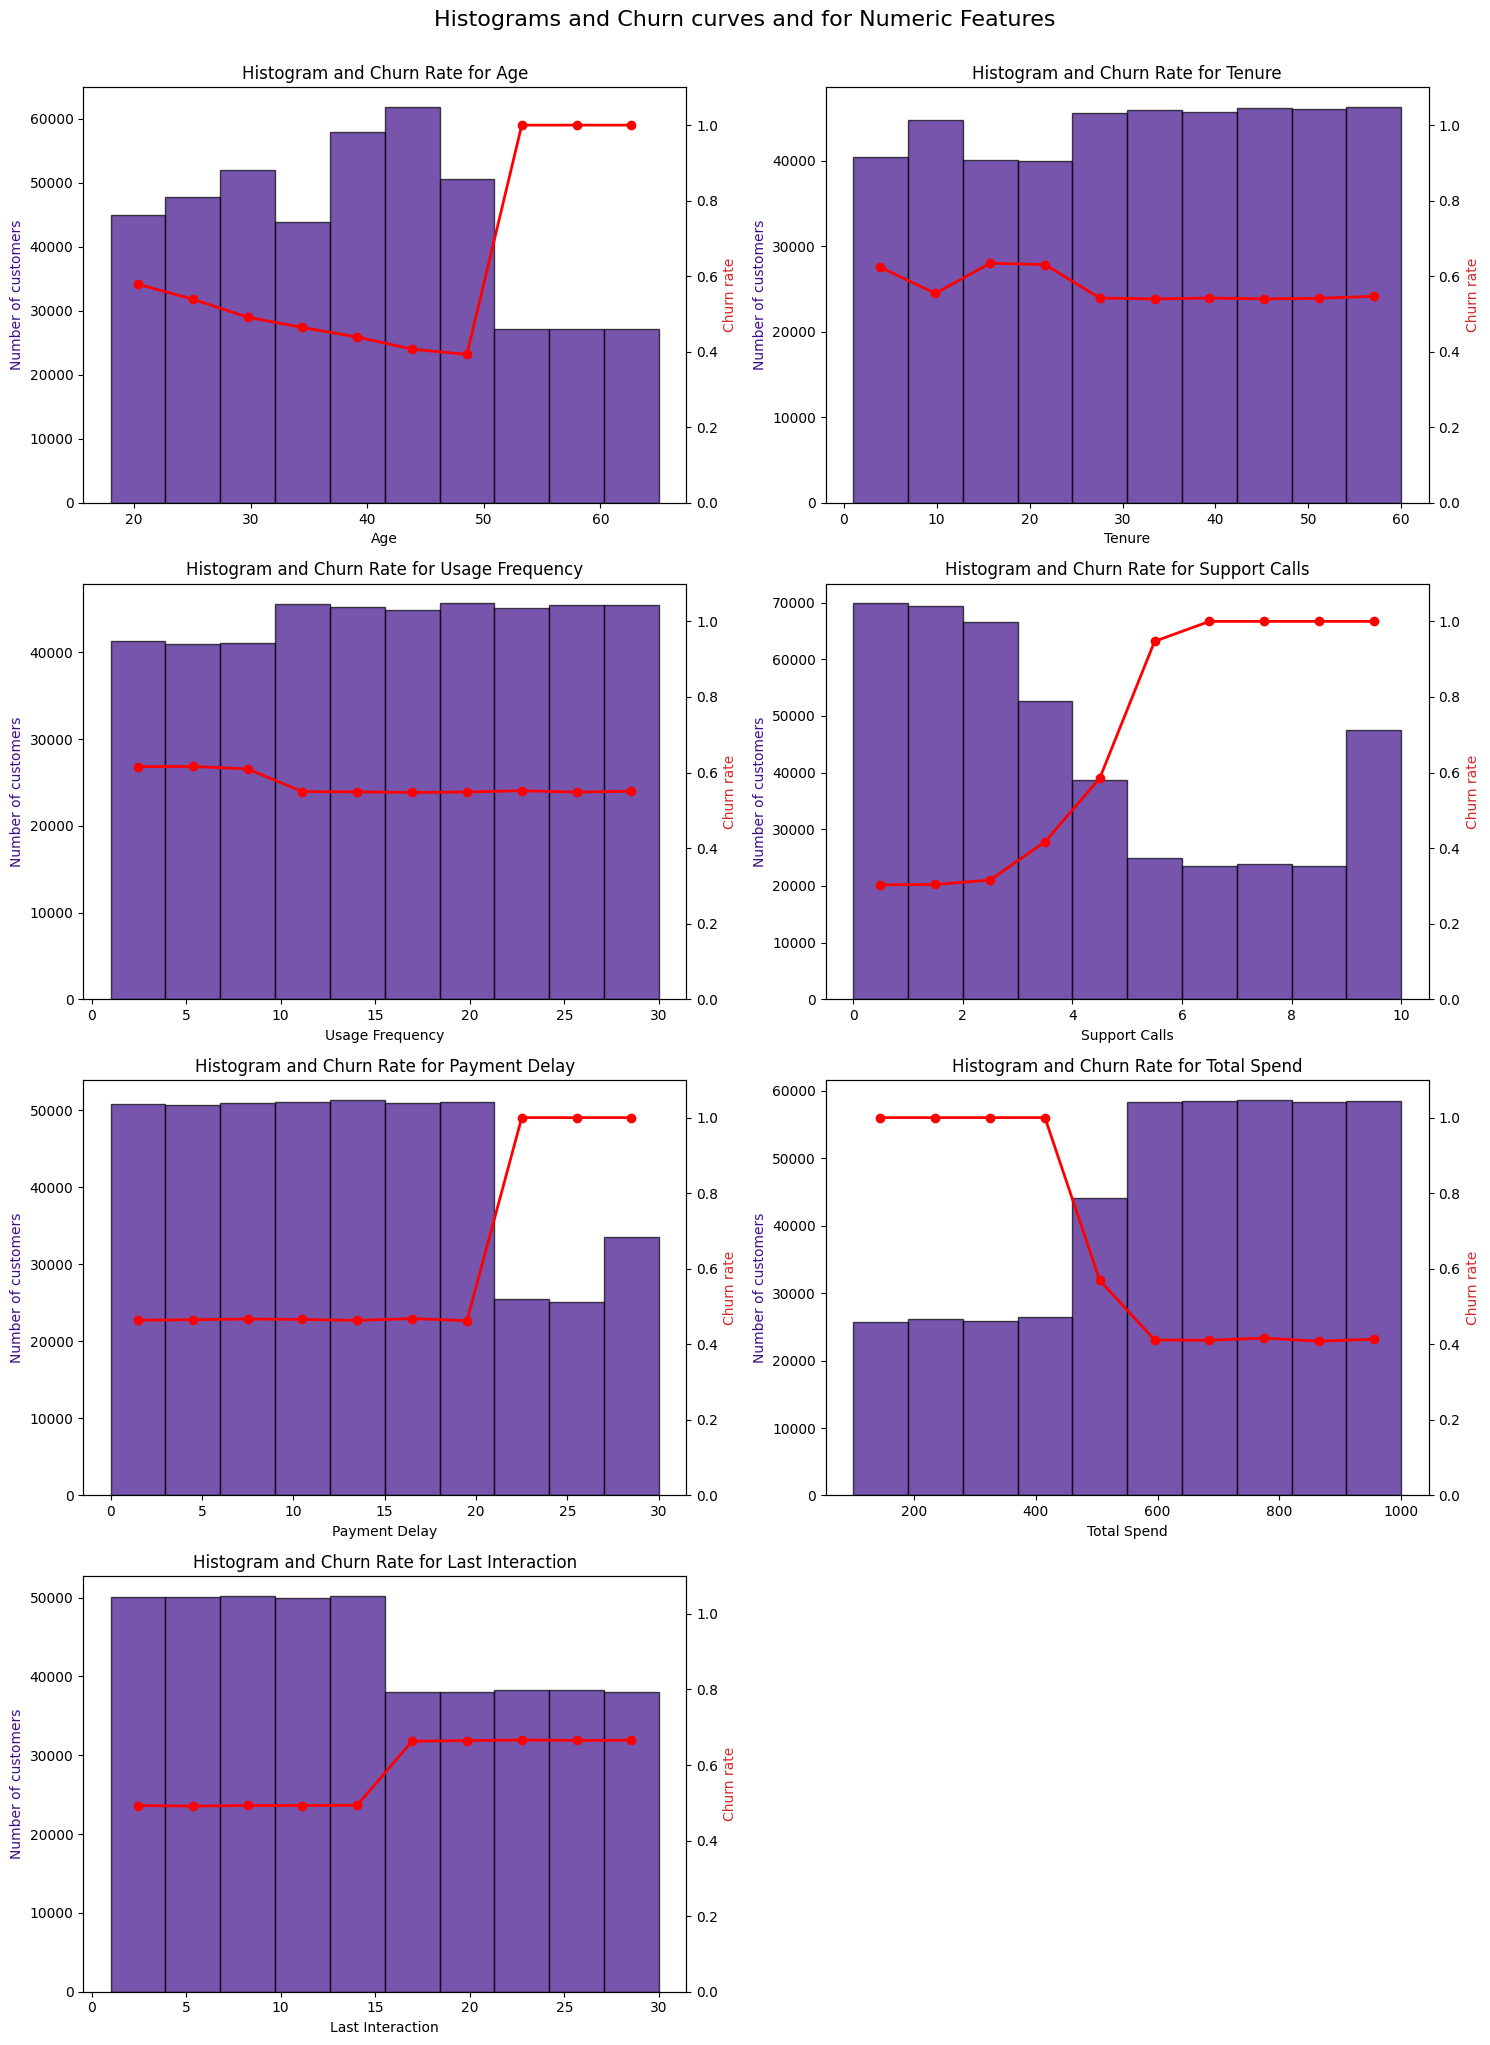

In [14]:
num_cols = 2
num_rows = int(np.ceil(len(numericFeatures) / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numericFeatures):
    ax1 = axes[i]

    n, bins, patches = ax1.hist(X_train[column], edgecolor='black', alpha=0.7, color='#3e0d8a')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Number of customers', color='#3e0d8a')

    # Calculate mean churn rate for each bin
    churn_rates = []
    for i in range(len(bins)-1):
        bin_mask = (X_train[column] >= bins[i]) & (X_train[column] < bins[i+1])
        churn_rates.append(y_train[bin_mask].mean())

    # Create a second y-axis to plot the churn rate
    ax2 = ax1.twinx()
    ax2.plot(bins[:-1] + np.diff(bins)/2, churn_rates, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Churn rate', color='tab:red')
    ax2.set_ylim(0, 1.1)

    ax1.set_title(f'Histogram and Churn Rate for {column}')

# Remove unused axes
for i in range(len(numericFeatures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms and Churn curves and for Numeric Features', fontsize=16, y=1.02)

plt.show()

Os gráficos acima contêm histogramas para a visualização das distribuições de cada uma das variáveis numéricas, bem como as proporções de churn desses mesmos segmentos nas colunas numéricas. Esse tipo de análise é importante porque permite ter um vislumbre inicial da distribuição dos dados, bem como a relação entre as variáveis e o churn.


#### Fatores indicativos de churn
- Pode-se observar que pessoas com idade acima de 55 anos, as taxas de cancelamento são mais elavadas. Esse padrão não se repete para pessoas mais jovens - pelo contrário, há uma tendência de queda de churn entre 20 e 50 anos. A partir desse ponto, há uma subida abrupta, gerando um indicativo claro de que o produto não se adapta bem ao público mais velho.
- Consumidores com mais de 20 de atraso no pagamento são grandes candidatos a cancelar o serviço. A taxa é muito alta a partir desse ponto, indicando um momento crucial na jornada do cliente.
- Muitas chamadas ao suporte, que intuitivamente indicam problemas com o serviço, também são um fator de churn. Quanto mais chamadas, maior a probabilidade de cancelamento e a partir de 5, é quase certo que o cliente irá deixar o serviço.
- Aqueles que menos gastam têm uma alta taxa de churn, indicando que o serviço não está sendo bem aproveitado ou que o cliente não vê valor nele.

Espera-se, portanto, que esses padrões sejam capturados e que seus impactos sejam refletidos nas previsões de churn. As demais features, apesar de inicialmente não apresentarem padrões claros a serem observados, são de grande relevância construção do modelo, uma vez que há uma série de relações mais complexas a serem exploradas.



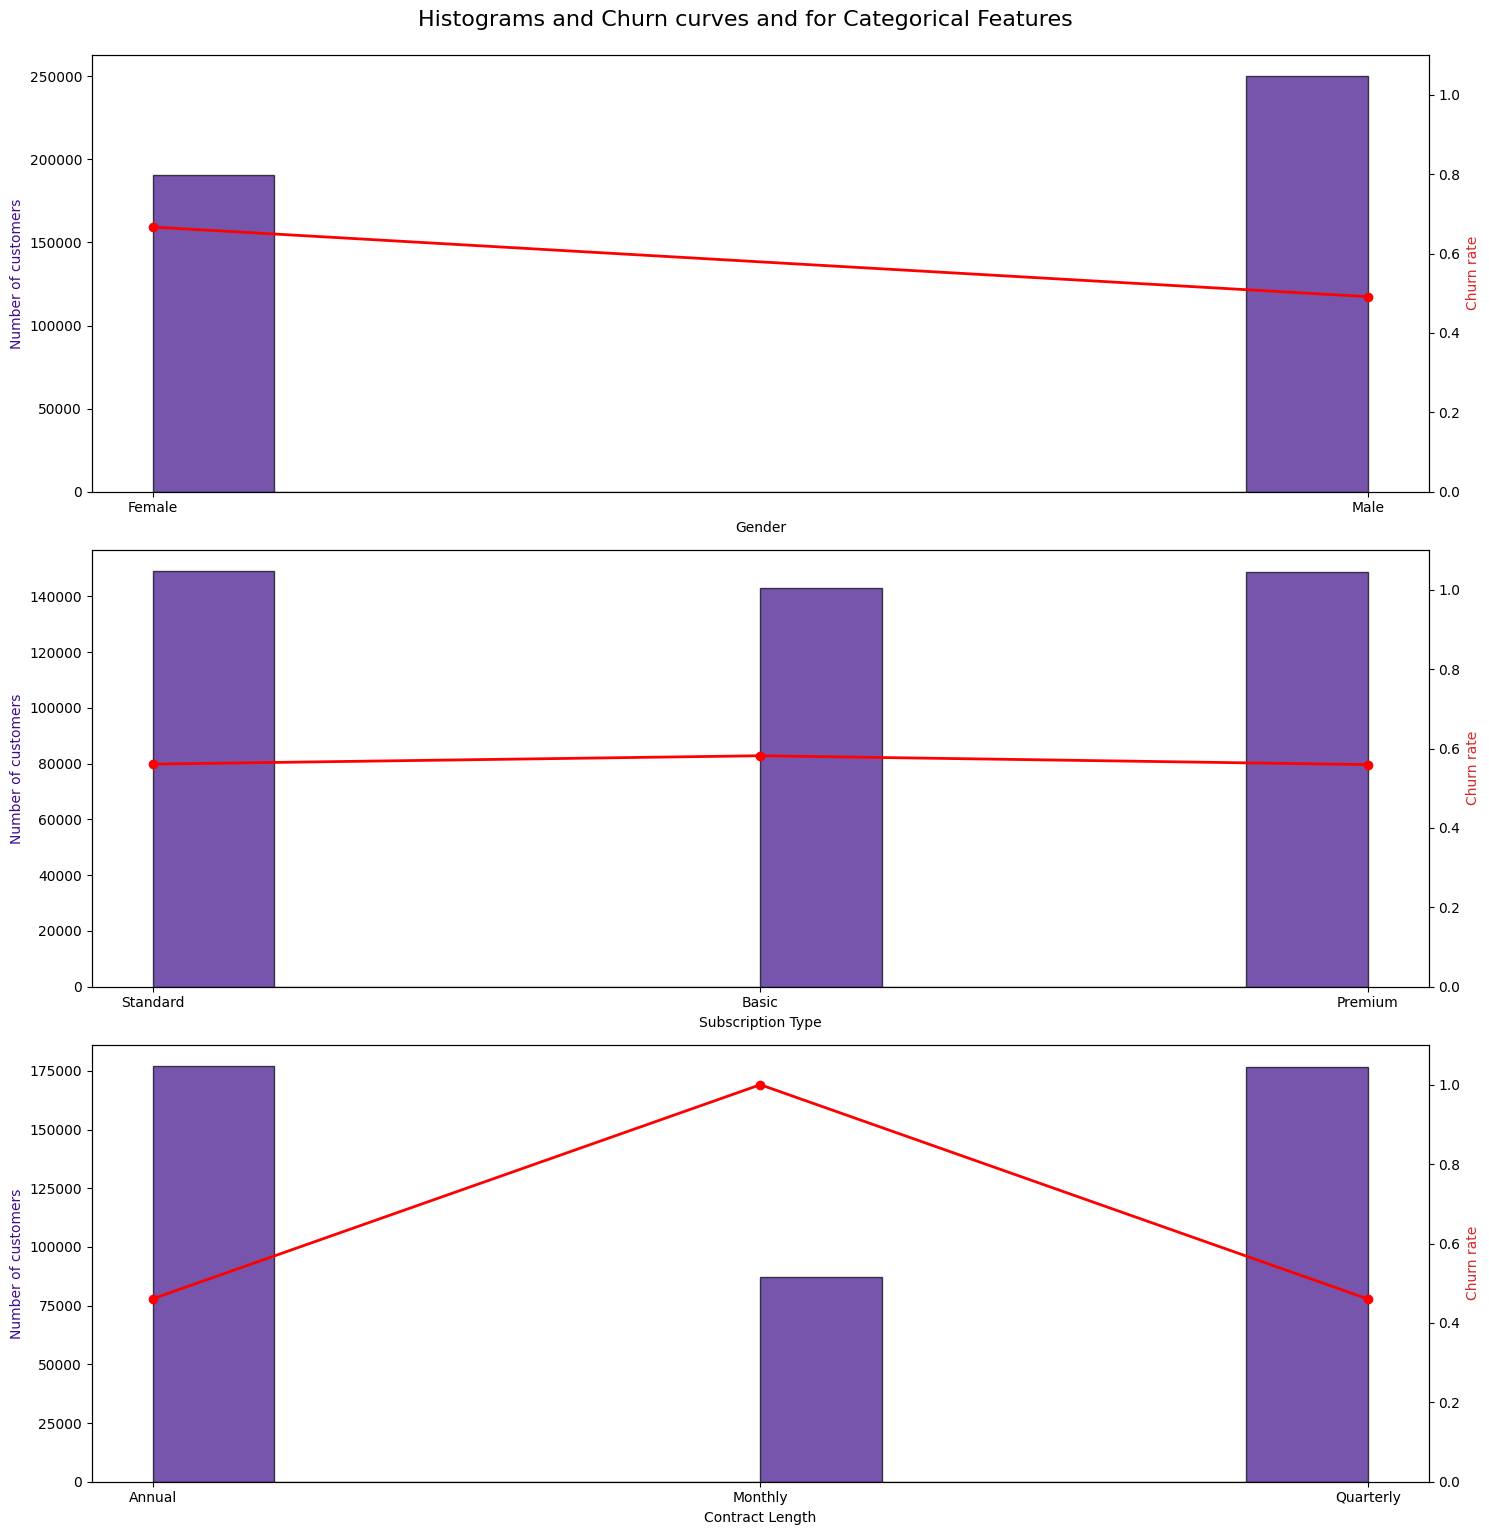

In [15]:
fig, axes = plt.subplots(len(categoricalFeatures), 1, figsize=(15, 5 * len(categoricalFeatures)))

for i, column in enumerate(categoricalFeatures):
    ax1 = axes[i]

    n, bins, patches = ax1.hist(X_train[column], edgecolor='black', alpha=0.7, color='#3e0d8a')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Number of customers', color='#3e0d8a')

    # Calculate mean churn rate for each bin
    churn_rates = []
    for category in X_train[column].unique():
        churn_rates.append(y_train[X_train[column] == category].mean())

    # Create a second y-axis to plot the churn rate
    ax2 = ax1.twinx()
    ax2.plot(X_train[column].unique(), churn_rates, color='red', marker='o', linestyle='-', linewidth=2)
    ax2.set_ylabel('Churn rate', color='tab:red')

    ax2.set_ylim(0, 1.1)

# Remove unused axes
for i in range(len(categoricalFeatures), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.suptitle('Histograms and Churn curves and for Categorical Features', fontsize=16, y=1.02)

plt.show()

Aqui são expostos os histogramas para as variáveis categóricas, indicando a quantidade de clientes em cada uma das subclasses, bem como suas respectivas proporções de churn. É notável que o tipo de assinatura não parece ter um impacto significativo na taxa de cancelamento e que esse número se mantém praticamente constante no por volta de 55% para standard, basic e premium. Além disso, os clientes do sexo masculino aparentam ter uma taxa de churn ligeiramente menor do que os do sexo feminino, apesar de serem a maioria entre os observados.

O fator mais proeminente a se analisar é que os contratos mensais são muito mais mais propensos a serem interrompidos do que os demais, com uma taxa de churn de quase 1. Esse número é aproximadamente o dobro do observado para os outros tipos.

#### Correlação entre variáveis

Um aspecto importante a ser considerado na análise exploratória de dados é a correlação entre as variáveis. Ela pode ser usada para identificar relações lineares entre os atributos, descartar variáveis redundantes, selecionar features, tal como entender melhor o comportamento dos dados.

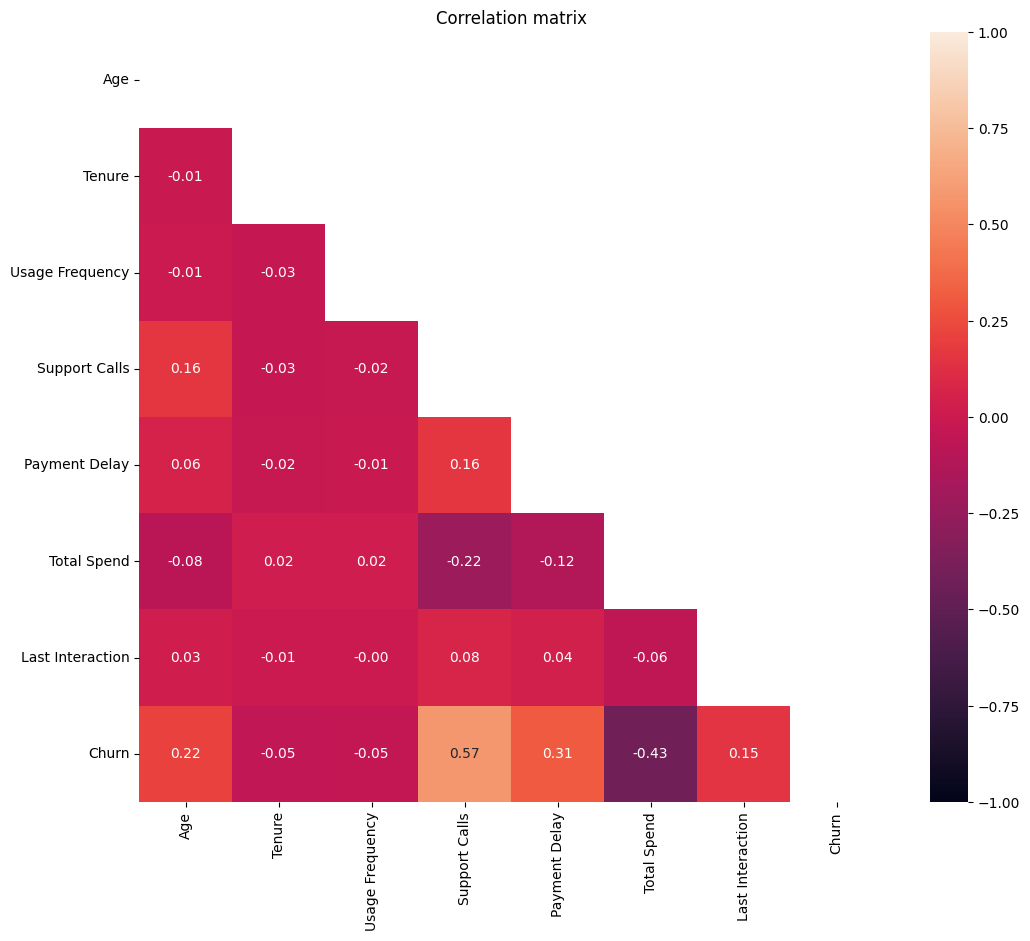

In [16]:
correlationMatrix = trainingData[correlationFeatures].corr()

# ignore upper triangle
mask = np.triu(np.ones_like(correlationMatrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlationMatrix, mask=mask, annot=True, fmt=".2f", cmap='rocket', vmin=-1, vmax=1)
plt.title('Correlation matrix')
plt.show()

A matriz de correlação acima mostra a relação entre as variáveis numéricas do conjunto de dados. A correlação varia de -1 a 1, onde -1 indica uma correlação negativa perfeita e 1, uma positiva.

A última linha, correspondente ao churn, indica como cada variável numérica se relaciona com o alvo de predição. Como observado pelos gráficos anteriores, o número de support calls e o tempo gasto são as features mais correlacionadas com o rótulo almejado.

Além disso, a correlação entre as variáveis numéricas é relativamente baixa, o que sugere que elas são independentes e podem fornecer informações úteis para a previsão do churn.

## Preparação para o desenvolvimento dos modelos
### One Hot Encoding

Foi aplicada a técnica de One Hot Encoding para transformar as variáveis categóricas em numéricas, de modo a permitir a entrada dos dados nos algoritmos de Aprenzidado de Máquina. O processo consiste em criar novas colunas booleanas para cada categoria presente, indicando a presença ou ausência da mesma. Um dos valores de cada tipo - que se tornaria uma coluna - foi suprimido a fim de evitar a armadilha da multicolinearidade. Dessa forma é possível recuperar o valor de gênero feminino a partir do oposto do masculino, por exemplo.

In [17]:
encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_encoded = encoder.fit_transform(X_train[categoricalFeatures])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categoricalFeatures))


X_test_encoded = encoder.transform(X_test[categoricalFeatures])
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categoricalFeatures))

X_train_encoded.head()

,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0


In [18]:
df_train_final = pd.concat([X_train.drop(columns=categoricalFeatures).reset_index(drop=True), X_train_encoded], axis=1)
df_test_final = pd.concat([X_test.drop(columns=categoricalFeatures).reset_index(drop=True), X_test_encoded], axis=1)

df_train_final.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Gender_Male,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Monthly,Contract Length_Quarterly
0,30.0,39.0,14.0,5.0,18.0,932.0,17.0,0.0,0.0,1.0,0.0,0.0
1,65.0,49.0,1.0,10.0,8.0,557.0,6.0,0.0,0.0,0.0,1.0,0.0
2,55.0,14.0,4.0,6.0,18.0,185.0,3.0,0.0,0.0,0.0,0.0,1.0
3,58.0,38.0,21.0,7.0,7.0,396.0,29.0,1.0,0.0,1.0,1.0,0.0
4,23.0,32.0,20.0,5.0,8.0,617.0,20.0,1.0,0.0,0.0,1.0,0.0


## Aplicação dos Modelos de Machine Learning
A seguir faremos a aplicação de diferentes modelos de Machine Learning para prever o churn dos clientes. A ideia é comparar o desempenho de diferentes algoritmos e identificar aquele que melhor se ajusta aos dados.

In [48]:
from sklearn.model_selection import train_test_split

# concatenate the training and test data
X = pd.concat([df_train_final, df_test_final])
y = pd.concat([y_train, y_test])

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
# Fist we define a function to calculate the some of the most important metrics for model evaluation
def calculate_metrics(y_true, y_pred):

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

def print_metrics(accuracy, precision, recall, f1):

    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 score: {f1:.2f}')

### Regressão Logística

In [59]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression(max_iter=2000)

logReg.fit(X_train2, y_train2)
predictions = logReg.predict(X_test2)

# Calculate the metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)

print_metrics(accuracy, precision, recall, f1)

Accuracy: 0.85
Precision: 0.87
Recall: 0.85
F1 score: 0.86


O primeiro algoritmo que avaliamos é o de Regressão Logística, especializado em classificação binária, é amplamente utilizado para prever o churn. Este é um modelo que mapeia uma combinação linear das variáveis de entrada para uma função logística, a qual é usada para calcular a probabilidade de um evento ocorrer.

Sua natureza é mais simples e interpretação mais direta, conhecida como 'white-box' em termos de explicabilidade. Isso significa que é possível entender como o modelo toma decisões e quais variáveis são mais importantes para a previsão. Por ser dessa forma, é um bom ponto de partida para a análise.

Seu desempenho foi razoável, com as todas as métricas avaliadas em pelo menos 85%.

### Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

accuracies = []
precisions = []
recalls = []
f1_scores = []

accuracies_in = []
precisions_in = []
recalls_in = []
f1_scores_in = []

for i in range(1, 101):
    decisionTree = DecisionTreeClassifier(max_depth=i)

    decisionTree.fit(X_train2, y_train2)
    predictions = decisionTree.predict(X_test2)

    # Calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    predictions_in = decisionTree.predict(X_train2)
    accuracy_in, precision_in, recall_in, f1_in = calculate_metrics(y_train2, predictions_in)
    accuracies_in.append(accuracy_in)
    precisions_in.append(precision_in)
    recalls_in.append(recall_in)
    f1_scores_in.append(f1_in)

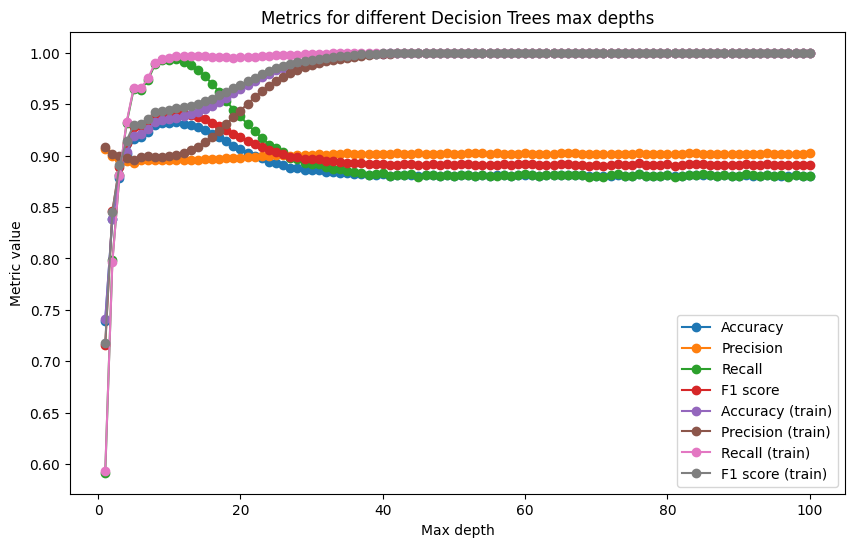

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), accuracies, label='Accuracy', marker='o')
plt.plot(range(1, 101), precisions, label='Precision', marker='o')
plt.plot(range(1, 101), recalls, label='Recall', marker='o')
plt.plot(range(1, 101), f1_scores, label='F1 score', marker='o')

plt.plot(range(1, 101), accuracies_in, label='Accuracy (train)', marker='o')
plt.plot(range(1, 101), precisions_in, label='Precision (train)', marker='o')
plt.plot(range(1, 101), recalls_in, label='Recall (train)', marker='o')
plt.plot(range(1, 101), f1_scores_in, label='F1 score (train)', marker='o')

plt.xlabel('Max depth')
plt.ylabel('Metric value')
plt.title('Metrics for different Decision Trees max depths')
plt.legend()
plt.show()


No gráfico pode-se observar as métricas de acurácia, recall, precisão e f1-score do modelo tanto para os dados de treinamento quanto para dados não vistos. É possível visualizar que elas têm um crescimento até o momento em que a profundidade da árvore de decisão é 11 para os dados inéditos. A partir desse momento, todas caem e se estabilizam em um valor menor. As curvas com as métricas de treinamento, por outro lado, continuam crescendo, indicando um ponto de overfitting do modelo.

Sendo assim, abaixo apresentamos os valores das métricas para a melhor árvore encontrada.

In [77]:
bestTree = DecisionTreeClassifier(max_depth=accuracies.index(max(accuracies))+1)

bestTree.fit(X_train2, y_train2)
predictions = bestTree.predict(X_test2)

# Calculate the metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)

print(f'Best tree max depth: {accuracies.index(max(accuracies))+1}')
print_metrics(accuracy, precision, recall, f1)


Best tree max depth: 11
Accuracy: 0.93
Precision: 0.90
Recall: 0.99
F1 score: 0.94


### Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train2, y_train2)
predictions = rf.predict(X_test2)

# Calculate the metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)

print_metrics(accuracy, precision, recall, f1)


Accuracy: 0.93
Precision: 0.90
Recall: 1.00
F1 score: 0.94


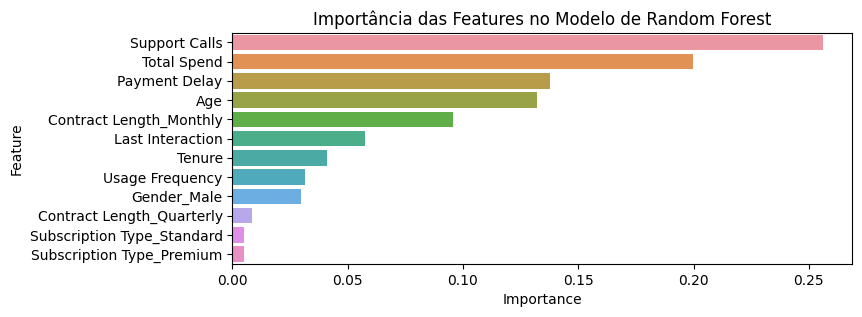

In [79]:
feature_importances = rf.feature_importances_
features = df_train_final.columns

importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 3))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features no Modelo de Random Forest')
plt.show()

O algoritmo Random Forest se mostrou muito eficaz na previsão do churn, com uma acurácia de 0.93. Isso significa que ele acertou 93% das previsões, um valor muito bom para um modelo de Machine Learning. Além disso, a precisão e o recall também foram altos, indicando que o modelo é capaz de identificar corretamente os clientes que estão propensos a cancelar o serviço.

Além disso, o gráfico acima revela que as features mais impactantes para a previsão com esse algoritmo são as mesmas que possuem uma alta correlação com o rótulo de churn. Isso sugere que o modelo está capturando bem as relações entre os dados e é capaz de fazer previsões precisas.

### Adaboost

In [92]:
numberOfEstimators = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
accuracies_ada = []
precisions_ada = []
recalls_ada = []
f1_scores_ada = []

In [93]:
for n in numberOfEstimators:
    adaBoost = AdaBoostClassifier(n_estimators=n, random_state=42)

    adaBoost.fit(X_train2, y_train2)
    predictions = adaBoost.predict(X_test2)

    # Calculate the metrics
    accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)
    accuracies_ada.append(accuracy)
    precisions_ada.append(precision)
    recalls_ada.append(recall)
    f1_scores_ada.append(f1)

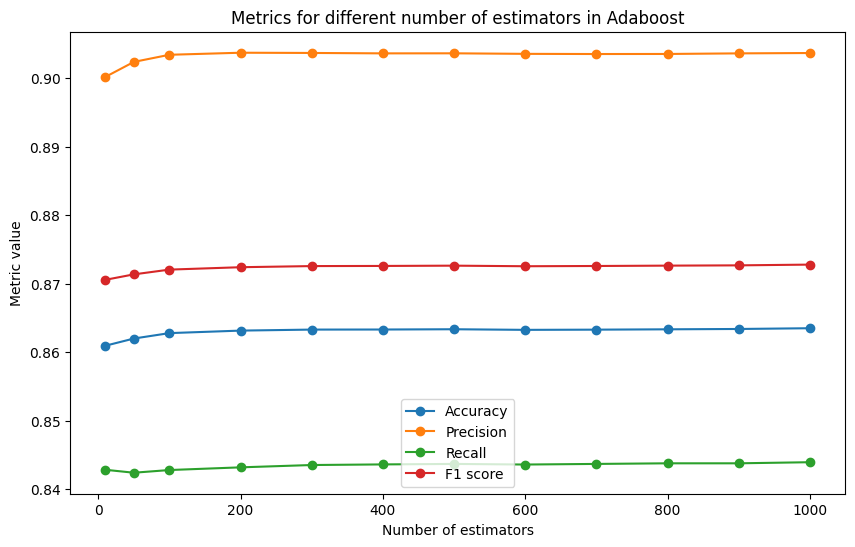

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(numberOfEstimators[-12:], accuracies_ada, label='Accuracy', marker='o')
plt.plot(numberOfEstimators, precisions_ada, label='Precision', marker='o')
plt.plot(numberOfEstimators, recalls_ada, label='Recall', marker='o')
plt.plot(numberOfEstimators, f1_scores_ada, label='F1 score', marker='o')

plt.xlabel('Number of estimators')
plt.ylabel('Metric value')
plt.title('Metrics for different number of estimators in Adaboost')
plt.legend()
plt.show()

In [95]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=400, random_state=42)

ada.fit(X_train2, y_train2)
predictions = ada.predict(X_test2)

# Calculate the metrics
accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)

print_metrics(accuracy, precision, recall, f1)


Accuracy: 0.86
Precision: 0.90
Recall: 0.84
F1 score: 0.87


## Rede Neural

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential()

model.add(Dense(units=12, input_dim=X_train2.shape[1], activation='relu'))

# Segunda camada oculta
model.add(Dense(units=32, activation='relu'))

# Terceira camada oculta
model.add(Dense(units=16, activation='relu'))

# Camada de saída
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train2, y_train2, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
10105/10105 [==============================] - 16s 1ms/step - loss: 0.4968 - accuracy: 0.7866 - val_loss: 0.4024 - val_accuracy: 0.8436
Epoch 2/50
10105/10105 [==============================] - 16s 2ms/step - loss: 0.4022 - accuracy: 0.8380 - val_loss: 0.4580 - val_accuracy: 0.7953
Epoch 3/50
10105/10105 [==============================] - 15s 1ms/step - loss: 0.3866 - accuracy: 0.8478 - val_loss: 0.3831 - val_accuracy: 0.8412
Epoch 4/50
10105/10105 [==============================] - 15s 2ms/step - loss: 0.3759 - accuracy: 0.8536 - val_loss: 0.3693 - val_accuracy: 0.8629
Epoch 5/50
10105/10105 [==============================] - 15s 1ms/step - loss: 0.3630 - accuracy: 0.8591 - val_loss: 0.3541 - val_accuracy: 0.8665
Epoch 6/50
10105/10105 [==============================] - 15s 1ms/step - loss: 0.3557 - accuracy: 0.8627 - val_loss: 0.3536 - val_accuracy: 0.8673
Epoch 7/50
10105/10105 [==============================] - 15s 1ms/step - loss: 0.3489 - accuracy: 0.8664 - val_loss: 0

In [ ]:
loss, accuracy = model.evaluate(X_test2, y_test2)
print(f'Test Accuracy: {accuracy:.4f}')

3158/3158 [==============================] - 4s 1ms/step - loss: 0.2740 - accuracy: 0.9056
Test Accuracy: 0.9056


### XGBoost

In [ ]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

xgb_model.fit(X_train2, y_train2)

predictions = xgb_model.predict(X_test2)

accuracy, precision, recall, f1 = calculate_metrics(y_test2, predictions)
print_metrics(accuracy, precision, recall, f1)

Accuracy: 0.93
Precision: 0.90
Recall: 0.99
F1 score: 0.94


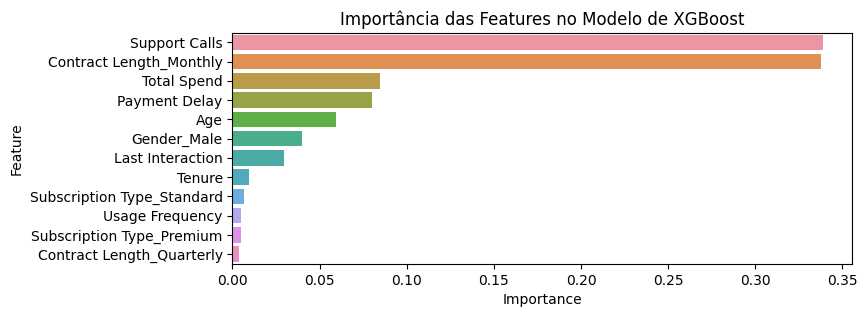

In [ ]:
feature_importances = xgb_model.feature_importances_

importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 3))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features no Modelo de XGBoost')
plt.show()

O XGBoost, assim como o Random Forest, apresentou excelentes resultados para todas as métricas avaliadas. No entanto, a importancia das features foi diferente, com Contract Length Monthly tendo um impacto muito mais significativo. Isso sugere uma visão distinta do modelo sobre o problema, o que pode ser útil para a tomada de decisões, porém deve ser investigado mais a fundo.

## Melhorando o Desempenho dos modelos observados

Dentre os modelos analisados, aqueles que obtiveram as melhores medidas para as métricas de avaliação foram o Random Forest, o XGBoost e a árvore de Decisão. A seguir, serão apresentadas algumas técnicas para melhorar o desempenho desses algoritmos.

In [ ]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 11],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

# Obter os melhores parâmetros e o melhor modelo
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best Hyperparameters: {best_params}')

In [ ]:
best_y_pred = best_model.predict(X_test)

accuracy, precision, recall, f1 = calculate_metrics(y_test, best_y_pred)
print_metrics(accuracy, precision, recall, f1)